In [ ]:
import numpy as np
import  matplotlib.pyplot  as  plt 
from matplotlib import cm

from tqdm import tqdm

%matplotlib inline
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
         "text.color" : "c"}
plt.rcParams.update(params)#setup for dark the

import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/nlp'

Mounted at /content/drive
/content/drive/My Drive/nlp


## zadanie 3 heura

In [ ]:
def false_dice():
  a = np.random.choice(10)
  if a==0: return 1
  if 1==a: return 2
  if a==2: return 3
  if a==3: return 4
  if a==4: return 5
  else: return 6

def true_dice():
  a = np.random.choice(6)
  if a==0: return 1
  if 1==a: return 2
  if a==2: return 3
  if a==3: return 4
  if a==4: return 5
  else: return 6  

In [ ]:
def generate_scores(n):
  curr_dice = True
  scores = []
  dice = []
  for i in range(n):
    if curr_dice == True:
      next = true_dice()
      scores.append(next)
      dice.append(curr_dice)
      change_prop = np.random.choice(100)
      if change_prop < 4:
        curr_dice = False
    else:
      next = false_dice()
      scores.append(next)
      dice.append(curr_dice)
      change_prop = np.random.choice(100)
      if change_prop < 5:
        curr_dice = True
  return scores, dice
scores, dices = generate_scores(10000)

In [ ]:
x = [i for i in range(10000)]

<BarContainer object of 1000 artists>

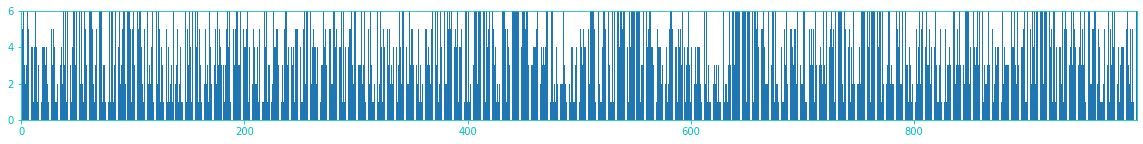

In [ ]:
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.margins(0)
ax.bar(x[:1000], scores[:1000])

In [ ]:
for i in range(10000):
  if scores[i]==0:
    print(i)

In [ ]:
def guess_dice_heur(scores, ground_truth, a, b):
  guess = [True,True,True,True,True,True]
  dice = True
  for i in range(6,9994):
    count6 = scores[i-6:i+6].count(6)
    if count6 > a and dice == True:
      dice = False
      guess.append(dice)
    elif count6 < b and dice == False:
      dice = True
      guess.append(dice)
    else:
      guess.append(dice)
  guess.extend([dice,dice,dice,dice,dice,dice])
  score=0
  for i in range(len(guess)):
    if guess[i] == ground_truth[i]:
      score+=1
  return score/len(guess)


In [ ]:
res = []
for i in tqdm(range(1000)):
  scores, dices = generate_scores(10000)
  res.append(guess_dice_heur(scores, dices, 4, 3.1) )
heur_res = np.mean(res)
heur_res

100%|██████████| 1000/1000 [01:40<00:00,  9.95it/s]


0.8244581

## zadanie 3 a b

In [ ]:
def guess_dice_proper(scores, ground_truth, num=10000): # based on alpha and beta

  p1, p2 = 0.04, 0.05
  ground_truth = np.array(ground_truth).astype(int) 

  alpha = np.float128(np.ones((num,2)))
  alpha[0,:] = [1/2, 1/2]

  beta = np.float128(np.ones((num,2)))
  beta[num-1, :] = [1, 1]

  emission_true = [1/6,1/6,1/6,1/6,1/6,1/6]
  emission_false = [1/10,1/10,1/10,1/10,1/10,1/2]
  for i in range(1,num):
    alpha[i,0] = 2*np.exp(np.log(alpha[i-1,0]) + np.log(0.96) + np.log(emission_true[scores[i-1]-1])) + \
                      2*np.exp(np.log(alpha[i-1,1]) + np.log(0.05) + np.log(emission_false[scores[i-1]-1]))
    alpha[i,1] = 2*np.exp(np.log(alpha[i-1,0]) + np.log(0.04) + np.log(emission_true[scores[i-1]-1])) + \
                        2*np.exp(np.log(alpha[i-1,1]) + np.log(0.95) + np.log(emission_false[scores[i-1]-1]))    


 #   alpha[i,0] = 2*(alpha[i-1,0]*0.96*emission_true[scores[i-1]-1] + alpha[i-1,1]*0.05*emission_false[scores[i-1]-1])
 #   alpha[i,1] = 2*(alpha[i-1,0]*0.04*emission_true[scores[i-1]-1] + alpha[i-1,1]*0.95*emission_false[scores[i-1]-1])    
  for i in np.arange(num-2, -1, -1):
    beta[i,0] = 2*np.exp(np.log(beta[i+1,0]) + np.log(0.96) + np.log(emission_true[scores[i+1]-1])) + \
                      2*np.exp(np.log(beta[i+1,1]) + np.log(0.05) + np.log(emission_false[scores[i+1]-1]))
    beta[i,1] = 2*np.exp(np.log(beta[i+1,0]) + np.log(0.04) + np.log(emission_true[scores[i+1]-1])) + \
                        2*np.exp(np.log(beta[i+1,1]) + np.log(0.95) + np.log(emission_false[scores[i+1]-1]))    

    
    #beta[i,0] = 2*( beta[i+1,0]*0.96*emission_true[scores[i+1]-1] + beta[i+1,1]*0.05*emission_false[scores[i+1]-1])
    #beta[i,1] = 2*( beta[i+1,0]*0.04*emission_true[scores[i+1]-1] + beta[i+1,1]*0.95*emission_false[scores[i+1]-1])    

  res = []
  for i in range(num):
    sum = alpha[i,0]*beta[i,0] + alpha[i,1]*beta[i,1]
    max = np.argmax([np.log(alpha[i,0]) + np.log(beta[i,0]) - np.log(sum), np.log(alpha[i,1]) + np.log(beta[i,1]) - np.log(sum)])
    if max == 0:
      res.append(1)
    else:
      res.append(0)

  score = np.count_nonzero(res == ground_truth[:num])
  return alpha, beta, score

In [ ]:
res = []
for i in tqdm(range(20)):
  scores, dices = generate_scores(10000)
  a,b,score= guess_dice_proper(scores, dices, 10000)
  res.append(score/10000)
prop_res = np.mean(res)
prop_res

100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


0.8267599999999999

In [ ]:
res = []
for i in tqdm(range(50)):
  scores, dices = generate_scores(10000)
  a,b,score= guess_dice_proper(scores, dices, 10000)
  res.append(score/10000)
prop_res = np.mean(res)
prop_res

100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


0.8284920000000001

In [ ]:
scores, dices = generate_scores(10000)

a,b,score= guess_dice_proper(scores, dices, 10000)
score/10000

0.8318

In [ ]:
res = []
for i in tqdm(range(100)):
  scores, dices = generate_scores(10000)
  a,b,score= guess_dice_proper(scores, dices, 10000)
  res.append(score/10000)
prop_res = np.mean(res)
prop_res

100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


0.8273279999999998

## zadanie 4

In [ ]:
def generate_random_model():
  p1, p2 = 0, 0
  emission1, emission2 = [0,0,0,0,0,0], [0,0,0,0,0,0]
  p1 = random.random()
  p2 = random.random()
  emission1 = np.random.rand(1,6)
  emission2 = np.random.rand(1,6)
  emission1 /= np.sum(emission1)
  emission2 /= np.sum(emission2)

  return [p1,p2, emission1, emission2]
model1 = generate_random_model()

In [ ]:
def generate_data_from_model(model, n=10000):
  curr_dice = True
  scores = []
  dice = []
  for i in range(n):
    if curr_dice == True:
      next = np.random.choice([1,2,3,4,5,6], p=model[2].ravel())
      scores.append(next)
      dice.append(curr_dice)
      change_prop = random.random()
      if change_prop < model[0]:
        curr_dice = False
    else:
      next = np.random.choice([1,2,3,4,5,6], p=model[3].ravel())
      scores.append(next)
      dice.append(curr_dice)
      change_prop = random.random()
      if change_prop < model[1]:
        curr_dice = True
  return [scores, dice]ka
  
data_model1 = generate_data_from_model(model1, 100)

In [ ]:
np.random.rand(1,1)

array([[0.41012414]])

In [ ]:
def alphabeta(dices, model):
  p1 = model[0]
  p2 = model[1]
  diceOne = model[2].ravel()
  diceTwo = model[3].ravel()
  def add(a,b):
    if a>b:
      c=b
      b=a
      a=c
    return a + np.log(1+np.exp(b-a))
  dices = [int(i) for i in dices]

  dp = [[0,0,0] for i in range(len(dices)+10)]
  dp[1][1] = np.log(1)
  dp[1][2] = np.log(1e-50)
  for i in range(2, len(dices)+1):
    dp[i][1] = add(dp[i-1][1]+np.log((1-p1)*diceOne[dices[i-1]]), dp[i-1][2]+np.log(p2*diceOne[dices[i-1]]))
    dp[i][1] = add(dp[i-1][2]+np.log((1-p2)*diceTwo[dices[i-1]]), dp[i-1][1]+np.log(p1*diceTwo[dices[i-1]]))

  dpBack = [[0,0,0] for i in range(len(dices)+10)]
  dpBack[len(dices)+1][1] = np.log(1)
  dpBack[len(dices)+1][2] = np.log(1)
  for i in range(len(dices), 0, -1):
    dpBack[i][1] = add(dpBack[i+1][1]+np.log((1-p1)*diceOne[dices[i-1]]), dpBack[i+1][2]+np.log(p2*diceOne[dices[i-1]]))
    dpBack[i][1] = add(dpBack[i_1][2]+np.log((1-p2)*diceTwo[dices[i-1]]), dpBack[i+1][1]+np.log(p1*diceTwo[dices[i-1]]))

  answer = ""
  for i in range(1,len(dices)+1):
    if dp[i][1] + dpBack[i][1] > dp[i][2] + dpBack[i][2]:
      answer += '1'
    else: answer += '2'
  return answer


def alphabeta_prop(dices, model):
  p1 = model[0]
  p2 = model[1]
  diceOne = model[2].ravel()
  diceTwo = model[3].ravel()
  def add(a,b):
    if a>b:
      c=b
      b=a
      a=c
    return a + np.log(1+np.exp(b-a))
  dices = [int(i) for i in dices]

  dp = [[0,0,0] for i in range(len(dices)+10)]
  dp[1][1] = np.log(1)
  dp[1][2] = np.log(1e-50)
  for i in range(2, len(dices)+1):
    dp[i][1] = add(dp[i-1][1]+np.log((1-p1)*diceOne[dices[i-1]]), dp[i-1][2]+np.log(p2*diceOne[dices[i-1]]))
    dp[i][1] = add(dp[i-1][2]+np.log((1-p2)*diceTwo[dices[i-1]]), dp[i-1][1]+np.log(p1*diceTwo[dices[i-1]]))

  dpBack = [[0,0,0] for i in range(len(dices)+10)]
  dpBack[len(dices)+1][1] = np.log(1)
  dpBack[len(dices)+1][2] = np.log(1)
  for i in range(len(dices), 0, -1):
    dpBack[i][1] = add(dpBack[i+1][1]+np.log((1-p1)*diceOne[dices[i-1]]), dpBack[i+1][2]+np.log(p2*diceOne[dices[i-1]]))
    dpBack[i][1] = add(dpBack[i_1][2]+np.log((1-p2)*diceTwo[dices[i-1]]), dpBack[i+1][1]+np.log(p1*diceTwo[dices[i-1]]))

  answer = []
  for i in range(1,len(dices)+1):
    tmp1 = dp[i][1] + dpBack[i][1]
    tmp2 = dp[i][2] + dpBack[i][2]
    answer.append([1/(1+np.exp(tmp2-tmp1)), 1/(1+np.exp(tmp1-tmp2))])
  return answer

def baum_welch(dices, iter = 100):

  def createModel(dices, answer, model):
    def countPattern(number):
      allTries = 0
      goodCounts = 0
      for i in range(len(dices)-1):
        if number==0:
          allTries +=answer[i][number] + model[2].ravel()[int(dices[i]-1)] * \
              answer[i+1][number^1]*model[0] + answer[i+1][number]*(1-model[1])
          goodCounts+=answer[i][number] + answer[i+1][number^1] * model[3].ravel()[int(dices[i])-1]*model[0]
        else:
          allTries +=answer[i][number] + model[3].ravel()[int(dices[i]-1)] * \
              answer[i+1][number^1]*model[1] + answer[i+1][number]*(1-model[2])
          goodCounts+=answer[i][number] + answer[i+1][number^1] * model[4].ravel()[int(dices[i])-1]*model[1]
      if allTries == 0:
        return 0.5
      return goodCounts/allTries

    def countProbabilities(number):
      probs = [0,0,0,0,0,0]
      for i in range(len(dices)):
        probs[int(dices[i])-1] += answer[i][number]
      normalize = sum(probs)
      if normalize == 0.0:
        probs = [0.16666666666666,0.16666666666666,0.16666666666666,0.16666666666666,0.16666666666666,0.16666666666666]
      else:
        for i in range(len(probs)):
          probs[i] /= normalize
      return probs

    model = [0,0,[0,0,0,0,0,0],[0,0,0,0,0,0]]
    model[0] = countPattern(0)
    model[1] = countPattern(1)
    model[2] = countProbabilities(0)
    model[3] = countProbabilities(1)
    return model

  currentModel = [0,0,[0,0,0,0,0,0],[0,0,0,0,0,0]]
  learningRate = 0.01
  for i in range(iterations):
    resultModel = createModel(dices, alphabeta_prop(dices, currentModel), currentModel)
    print(currentModel)
    currentModel = currentModel + (1-learningRate)+resultModel*learningRate
  return currentModel




In [ ]:
model = generate_random_model()



In [ ]:
random.random()

0.3584124000056039